# Random Forest Classifier

In [1]:
import some_load_train_evaluate_functions as ml

from sklearn.ensemble import RandomForestClassifier

In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Diabetes data

diabetes_df = ml.get_data_of_disease(driver, 'Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


In [4]:
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)

## Preprocessing

### Median Imputation

In [63]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.975

F1-Score: 0.985

Confusion Matrix:

[[3071    2]
 [  12  472]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3073
     Class 1       1.00      0.98      0.99       484

    accuracy                           1.00      3557
   macro avg       1.00      0.99      0.99      3557
weighted avg       1.00      1.00      1.00      3557


ROC-AUC Curve:


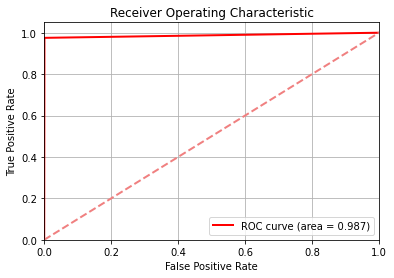

In [64]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)

## Cross Validation

### K-fold

In [66]:
ml.k_cross_validate(random_forest,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.93932584 0.93820225 0.94494382 0.93250844 0.92575928 0.93813273
 0.94825647 0.94825647 0.928009   0.94150731]

Mean accuracy score:  0.9384901606400323

Standard deviation:  0.007417105548804119


### Stratified K-fold

In [67]:
ml.stratified_k_cross_validate(random_forest,X,y,n_splits=10)


Average Accuracy: 0.9371429835315528

Average Precision: 0.8612109769655223

Average Recall: 0.6225191945530929

Average F1-Score: 0.7218173395066076


## Feature Selection

### Correlation Analysis

In [68]:
random_forest_test = RandomForestClassifier(random_state=42, n_jobs=-1)

In [69]:
pos_corr, neg_corr = ml.get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

corr_features = ['Gender'] + list(pos_corr.keys()[1:10]) + list(neg_corr.keys()[:10]) 

In [70]:
ml.k_cross_validate(random_forest_test,X[corr_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.94044944 0.93033708 0.94157303 0.9336333  0.92125984 0.93813273
 0.94825647 0.94938133 0.93475816 0.93475816]

Mean accuracy score:  0.9372539528064611

Standard deviation:  0.007918259115645119


### SelectFromModel

In [71]:
sfm_features = ml.select_from_model_features(RandomForestClassifier(),X,y)
sfm_features

['Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Fasting Glucose [mmol/L]',
 'Glycohemoglobin [%]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]']

In [72]:
sfm_features = list(sfm_features)

ml.k_cross_validate(random_forest_test,X[sfm_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.93595506 0.9247191  0.94382022 0.93588301 0.92350956 0.93138358
 0.94713161 0.94600675 0.92913386 0.93138358]

Mean accuracy score:  0.934892632802922

Standard deviation:  0.00803736958746165


### SelectKBest

In [73]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

array(['Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]', 'Age', 'BMI',
       'Blood Urea Nitrogen [mg/dL]', 'Retinol [umol/L]',
       'Osmolality [mmol/Kg]', 'Insulin [pmol/L]',
       'Alpha-tocopherol [umol/L]', 'Lymphocyte [%]',
       'Neutrophil_Lymphocyte Ratio', 'Ferritin [ng/mL]',
       'Segmented neutrophils [%]', 'Albumin [g/dL]',
       'C-Reactive Protein [mg/L]', 'Creatinine [mg/dL]',
       'Triglyceride [mmol/L]', 'Lymphocyte_C-Reactive Protein Ratio',
       'Triglyceride_HDL Ratio', 'Red cell distribution width [%]',
       'Platelet_WBC Ratio', 'Alpha-crypotoxanthin [umol/L]',
       'Direct HDL-Cholesterol [mmol/L]', 'Chloride [mmol/L]',
       'Total Cholestrol_HDL Ratio', 'Gamma Glutamyl Transferase [IU/L]',
       'Gamma-tocopherol [umol/L]', 'A/G Ratio',
       'Platelet count [1000 cells/uL]',
       '25-hydroxyvitamin D2 + D3 [nmol/L]'], dtype=object)

In [74]:
ml.k_cross_validate(random_forest_test,X[k_best_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.93820225 0.93370787 0.93932584 0.93475816 0.92350956 0.93925759
 0.94713161 0.94600675 0.93250844 0.93925759]

Mean accuracy score:  0.9373665651344142

Standard deviation:  0.006461468984022926


### Recursive Feature Elimination (RFE) 

In [75]:
rfe_features = ml.select_rfe_features(RandomForestClassifier(),X,y,n=0.2,step=0.5)
rfe_features[:30]

array(['C-Reactive Protein [mg/L]', 'Retinol [umol/L]',
       'Osmolality [mmol/Kg]', 'Lymphocyte_C-Reactive Protein Ratio',
       'Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]',
       'Creatinine [mg/dL]', 'Direct HDL-Cholesterol [mmol/L]',
       'Cobalt [nmol/L]', 'Gamma Glutamyl Transferase [IU/L]',
       'Total Cholesterol [mmol/L]', 'Alpha-crypotoxanthin [umol/L]',
       'Blood Urea Nitrogen [mg/dL]', 'Age',
       'Beta-cryptoxanthin [umol/L]', 'BMI',
       '25-hydroxyvitamin D2 + D3 [nmol/L]', 'Vitamin C [umol/L]',
       'Monocyte [%]', 'Non_HDL Ratio', 'Transferrin receptor [nmol/L]',
       'Platelet count [1000 cells/uL]', 'Blood cadmium [nmol/L]',
       'Platelet_WBC Ratio', 'Triglyceride_HDL Ratio',
       'RBC count [million cells/uL]', 'Trans-lycopene [umol/L]',
       'Trans-beta-carotene [umol/L]', 'Total Lycopene [umol/L]',
       'Platelet_Lymphocyte Ratio'], dtype=object)

In [76]:
ml.k_cross_validate(random_forest_test,X[rfe_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.93932584 0.93146067 0.94157303 0.928009   0.92575928 0.93925759
 0.95050619 0.94600675 0.93025872 0.94263217]

Mean accuracy score:  0.9374789246849764

Standard deviation:  0.007795550539569157


### Lasso Regularization

In [77]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'Gender',
 'BMI',
 'Osmolality [mmol/Kg]',
 'Alkaline Phosphatase [IU/L]',
 'Non_HDL Ratio',
 'Total Cholesterol [mmol/L]',
 'Retinol [umol/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Blood lead [umol/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Vitamin C [umol/L]',
 'Transferrin Saturation [%]',
 'Insulin [pmol/L]',
 'Transferrin receptor [nmol/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Sodium [mmol/L]',
 'Aspartate Aminotransferase [U/L]',
 'Creatinine [mg/dL]',
 'Creatine Phosphokinase [IU/L]',
 'Uric Acid [mg/dL]',
 'Chloride [mmol/L]',
 'Albumin [g/dL]',
 'Lactate Dehydrogenase [IU/L]',
 'Bicarbonate [mmol/L]',
 'Blood selenium [umol/L]',
 'Alpha-carotene [umol/L]']

In [78]:
ml.k_cross_validate(random_forest_test,X[l1_selected_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.93820225 0.92921348 0.94044944 0.9336333  0.92125984 0.94150731
 0.94825647 0.94713161 0.93250844 0.94150731]

Mean accuracy score:  0.9373669443005017

Standard deviation:  0.007885924556434573


### Relief F

In [79]:
relieff_features = ml.relief_feature_select(30,X,y)

In [80]:
relieff_features_ = relieff_features[:30]
relieff_features_

['Age',
 'Glycohemoglobin [%]',
 'BMI',
 'Segmented neutrophils [%]',
 'Fasting Glucose [mmol/L]',
 'Lymphocyte [%]',
 'Hematocrit [%]',
 'Hemoglobin [g/dL]',
 'Retinol [umol/L]',
 'Potassium [mmol/L]',
 'Mean cell volume [fL]',
 'Total Cholesterol [mmol/L]',
 'Osmolality [mmol/Kg]',
 'Blood Urea Nitrogen [mg/dL]',
 'Phosphorus [mg/dL]',
 'Albumin [g/dL]',
 'Chloride [mmol/L]',
 'Non_HDL Ratio',
 'Total Protein [g/dL]',
 'Neutrophil_Lymphocyte Ratio',
 'Mean platelet volume [fL]',
 'Mean cell hemoglobin [pg]',
 'Total Iron Binding Capacity [umol/L]',
 'Platelet count [1000 cells/uL]',
 'Alpha-tocopherol [umol/L]',
 'Uric Acid [mg/dL]',
 'RBC count [million cells/uL]',
 'Lactate Dehydrogenase [IU/L]',
 'Gamma-tocopherol [umol/L]',
 'Total Cholestrol_HDL Ratio']

In [81]:
ml.k_cross_validate(random_forest_test,X[relieff_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.94157303 0.93146067 0.94269663 0.93588301 0.9223847  0.94150731
 0.94600675 0.94488189 0.93025872 0.93813273]

Mean accuracy score:  0.9374785455188889

Standard deviation:  0.007119708110417177


### Random Forest Feature Importances

In [82]:
def get_rand_forest_features(model, X_train):
    random_forest_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    random_forest_features = random_forest_features.sort_values('Importance', ascending=False)
    random_forest_features = list(random_forest_features.index)
    
    return random_forest_features

In [83]:
random_forest_features = get_rand_forest_features(random_forest, X_train)
random_forest_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Cobalt [nmol/L]',
 'Triglyceride_HDL Ratio',
 'Total Cholesterol [mmol/L]',
 'Retinol [umol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Creatinine [mg/dL]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Chloride [mmol/L]',
 'Triglyceride [mmol/L]',
 'Insulin [pmol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Non_HDL Ratio',
 'C-Reactive Protein [mg/L]',
 'Transferrin receptor [nmol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Alpha-tocopherol [umol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Ferritin [ng/mL]',
 'Trans-beta-carotene [umol/L]',
 'Platelet count [1000 cells/uL]',
 'Gamma-tocopherol [umol/L]',
 'Platelet_WBC Ratio',
 'A/G Ratio']

In [84]:
ml.k_cross_validate(random_forest_test,X[random_forest_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.93932584 0.93033708 0.94382022 0.93138358 0.92125984 0.94038245
 0.94825647 0.94825647 0.9336333  0.94038245]

Mean accuracy score:  0.9377037701747956

Standard deviation:  0.00811354530172936


### Ensemble of Feature Sets

In [85]:
# We can also create a feature set from the above sets by selecting commonly occuring features

list1 = list(corr_features)
list2 = list(k_best_features)
list3 = list(sfm_features)
list4 = list(rfe_features)
list5 = list(l1_selected_features)
list6 = list(relieff_features)
list7 = list(random_forest_features)

combined_list = list1 + list2 + list3 + list4 + list5 + list6 + list7
feature_counts = ml.Counter(combined_list)
min_count = 6

combined_features = [feature for feature, count in feature_counts.items() if count >= min_count]
# combined_features = [x for x in relieff_features if x in combined_features]     # order based on releif features
combined_features

['Gender',
 'Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Triglyceride [mmol/L]',
 'Total Lycopene [umol/L]',
 'Trans-lycopene [umol/L]',
 'Platelet count [1000 cells/uL]',
 'A/G Ratio',
 'Chloride [mmol/L]',
 'Platelet_WBC Ratio',
 'Direct HDL-Cholesterol [mmol/L]',
 'Albumin [g/dL]',
 'Alpha-crypotoxanthin [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio']

In [86]:
ml.k_cross_validate(random_forest_test,X[combined_features],y,cv=10,scoring='accuracy')


accuracy scores: [0.94044944 0.93033708 0.94157303 0.9336333  0.92125984 0.93813273
 0.94825647 0.94938133 0.93475816 0.93475816]

Mean accuracy score:  0.9372539528064611

Standard deviation:  0.007918259115645119



Maximum accuracy = 0.9402 for 37 features


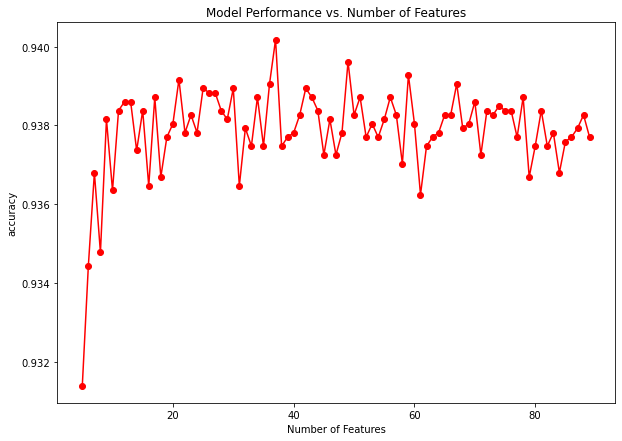

In [87]:
# Optimal no. of features

final_features = list(random_forest_features) 

ml.plot_num_feature_performance(random_forest_test,  X, y, final_features, scoring='accuracy')


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.991

Recall: 0.970

F1-Score: 0.981

Confusion Matrix:

[[3082    4]
 [  14  457]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3086
     Class 1       0.99      0.97      0.98       471

    accuracy                           0.99      3557
   macro avg       0.99      0.98      0.99      3557
weighted avg       0.99      0.99      0.99      3557


ROC-AUC Curve:


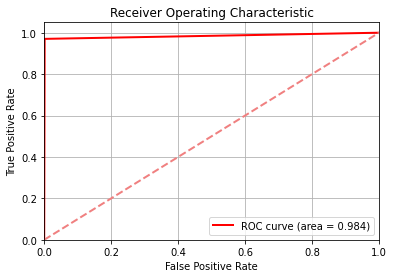

In [88]:
selected = random_forest_features[:37]

X = X[selected]
X_train = X_train[selected]
X_test = X_test[selected]

random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest, X_train, y_train, X_test, y_test)

In [89]:
ml.k_cross_validate(random_forest,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94382022 0.93258427 0.94269663 0.94038245 0.9223847  0.94150731
 0.94825647 0.95388076 0.93475816 0.94150731]

Mean accuracy score:  0.9401778288949835

Standard deviation:  0.008245323267855636


## Hyperparameter Optimization 

### Grid Search

In [90]:
param_grid = {
    
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_jobs': [-1],
    'random_state': [42]

}

In [91]:
grid_best_params, random_forest_grid = ml.grid_search_optimize(random_forest, param_grid, X_train, y_train, cv=10)
grid_best_params

{'bootstrap': True,
 'criterion': 'gini',
 'max_features': 'log2',
 'n_jobs': -1,
 'random_state': 42}

In [92]:
random_forest_grid.fit(X_train, y_train)

ml.k_cross_validate(random_forest_grid,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94044944 0.93033708 0.94269663 0.93475816 0.9223847  0.93588301
 0.94600675 0.95050619 0.92913386 0.93588301]

Mean accuracy score:  0.9368038826607348

Standard deviation:  0.007968080220066733


### Optuna

In [93]:
def objective(trial):

    params = {
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1])
    }
     
    model = RandomForestClassifier(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = ml.accuracy_score(y_test, y_pred)

    return accuracy

In [94]:
# Hyperparameter Optimize

best_trial, random_forest_opt = ml.optuna_optimize(objective,RandomForestClassifier, n_trials=200)

best_trial

{'bootstrap': False, 'criterion': 'gini', 'n_jobs': -1}

In [95]:
random_forest_opt.fit(X_train, y_train)

ml.k_cross_validate(random_forest_opt,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.93707865 0.93033708 0.94382022 0.93700787 0.92688414 0.94038245
 0.94938133 0.94825647 0.93588301 0.93700787]

Mean accuracy score:  0.938603910466248

Standard deviation:  0.006783919358428683


## Cross Validation

In [96]:
# Cross-validation

ml.k_cross_validate(random_forest,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94382022 0.93258427 0.94269663 0.94038245 0.9223847  0.94150731
 0.94825647 0.95388076 0.93475816 0.94150731]

Mean accuracy score:  0.9401778288949835

Standard deviation:  0.008245323267855636


In [97]:
ml.stratified_k_cross_validate(random_forest,X,y,n_splits=10,random_state=42)


Average Accuracy: 0.9380419863247432

Average Precision: 0.8491807828210955

Average Recall: 0.6446979574098217

Average F1-Score: 0.7316864269570114


In [98]:
ml.k_cross_validate(random_forest_grid,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94044944 0.93033708 0.94269663 0.93475816 0.9223847  0.93588301
 0.94600675 0.95050619 0.92913386 0.93588301]

Mean accuracy score:  0.9368038826607348

Standard deviation:  0.007968080220066733


In [99]:
ml.stratified_k_cross_validate(random_forest_grid,X,y,n_splits=10,random_state=42)


Average Accuracy: 0.9393920703732259

Average Precision: 0.858856568272287

Average Recall: 0.6464001158916414

Average F1-Score: 0.7363361643236427


In [100]:
ml.k_cross_validate(random_forest_opt,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.93932584 0.92921348 0.94269663 0.93700787 0.92575928 0.93925759
 0.94713161 0.94938133 0.93025872 0.93813273]

Mean accuracy score:  0.9378165088914449

Standard deviation:  0.007252236950861922


In [101]:
ml.stratified_k_cross_validate(random_forest_opt,X,y,n_splits=10,random_state=42)


Average Accuracy: 0.9383799496972991

Average Precision: 0.8423777593047876

Average Recall: 0.6557945820657686

Average F1-Score: 0.7359708234897274


In [102]:
final_random_forest_estimator = random_forest_opt

In [103]:
# Saving the model

estimator_name = 'Random_Forest_Classifier'

ml.save_model(final_random_forest_estimator, f"../Models/Diabetes/{estimator_name}.pkl")

Overwrite File? [y/n]: y
Saved Model
